## Replication for Rust(1987)

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fixed_point
from numba import njit, float64, float32, int64, prange
from numba.experimental import jitclass

In [18]:
# Import the raw data
b1_raw = pd.read_csv("C:/Users/koala/Desktop/SFERS/응미2팀/replication/Rust(1987)/nxfp/data/original_data/g870.asc", header=None)
b1_raw = pd.DataFrame(b1_raw.values.reshape((15, int(len(b1_raw) / 15)))).T

b2_raw = pd.read_csv('C:/Users/koala/Desktop/SFERS/응미2팀/replication/Rust(1987)/nxfp/data/original_data/rt50.asc', header=None)
b2_raw = pd.DataFrame(b2_raw.values.reshape((4, int(len(b2_raw) / 4)))).T

b3_raw = pd.read_csv('C:/Users/koala/Desktop/SFERS/응미2팀/replication/Rust(1987)/nxfp/data/original_data/t8h203.asc', header=None)
b3_raw = pd.DataFrame(b3_raw.values.reshape((48, int(len(b3_raw) / 48)))).T

b4_raw = pd.read_csv('C:/Users/koala/Desktop/SFERS/응미2팀/replication/Rust(1987)/nxfp/data/original_data/a530875.asc', header=None)
b4_raw = pd.DataFrame(b4_raw.values.reshape((37, int(len(b4_raw) / 37)))).T

In [19]:
# Below is how 'b2_raw' looks like. We converted it from a vector to a matrix for basic wrangling (HGH)
b2_raw

,0,1,2,3
0,2386,2387,2388,2389
1,5,5,5,5
2,81,81,81,81
3,0,0,0,0
4,0,0,0,0
5,0,0,0,0
6,0,0,0,0
7,0,0,0,0
8,0,0,0,0
9,7,7,7,7


In [20]:
# Replacement happened at most of two times (HGH)
# Hence, month/year/odometer_replacement have their index 1 and 2 (HGH)
var_names = ['bus_number', 'month_purchased', 'year_purchased', 'month_replacement_1', 'year_replacement_1', 'odometer_replacement_1', 'month_replaement_2', 'year_replacement_2', 'odometer_replacement_2', 'month_begin', 'year_begin']

In [21]:
# -----------------------------Defining Functions------------------------------
# Extract the information fromt the raw data. This functions as the initialization
def extract_info(b):
    # Create separate dataframe for bus info
    new_index = ['' for x in range(11)]
    new_index[0] = var_names[0]
    new_index[1] = var_names[1]
    new_index[2] = var_names[2]
    new_index[3] = var_names[3]
    new_index[4] = var_names[4]
    new_index[5] = var_names[5]
    new_index[6] = var_names[6]
    new_index[7] = var_names[7]
    new_index[8] = var_names[8]
    new_index[9] = var_names[9]
    new_index[10] = var_names[10]

    # Note that the first 11 rows of matrix 'b' is about basic information about each of the bus. (HGH)
    # Extract them from 'b' and name the new matrix 'b_info'. (HGH)
    b_info = b.iloc[:11]
    b_info.index = new_index
    b_info = b_info.T.set_index('bus_number').T
    
    # Set bus number to be column headers
    b = b.T.set_index([0]).T
    
    # Drop bus info
    # Now that b contains only the accumulated odometer(milege) in observed period. (HGH)
    b = b[10:]
    
    # Add dates to row index
    # Since dates are not explicitly expressed in the matrix, we make the index(name of the rows) to be explicit date. (HGH)
    month = b_info.loc["month_begin"].values[0]
    year = b_info.loc["year_begin"].values[0]
    b.index = pd.date_range(f"{year}-{month}-01", periods=len(b), freq="MS")
    
    # Fix month and years of odometer replacements to be date corresponding to odometer replacement
    # Rust points out this differs in some cases
    # Indeed, most of the dates recorded as replacements were wrong (HGH)
    
    # col_map is a dictionary consisting of the nominal keys and bus number values (HGH)
    col_map = pd.DataFrame(b.columns).to_dict()[0]
    for o in ['1', '2']:
        # np.where returns two arrays each indicating the number of row and column.(HGH)
        # Combining the n-th element of each arrays we get the index(location) of the 'True' (HGH)
        x, y = np.where(b > b_info.loc[f'odometer_replacement_{o}', :])
        
        replacement = pd.DataFrame([x, y], index=['row', 'column']).T
        
        # RHS returns the numbers of time periods to the date of replacement from the start of observation (HGH)
        replacement = replacement.groupby('column').min()
        
        # change the index to the bus number (HGH)
        replacement.index = replacement.index.map(col_map)
        
        replacement[f'month_{o}'] = replacement['row'].apply(lambda x: b.index[x].month)
        replacement[f'year_{o}'] = replacement['row'].apply(lambda x: np.mod(b.index[x].year, 1900))
        replacement[f'replace_{o}'] = replacement['row'].apply(lambda x: pd.Timestamp(year=b.index[x].year, month=b.index[x].month, day=1))
        replacement[replacement.row == 0] = 0
        # Append checks to dataframe
        # Now that 'b_info' contains the original 11 rows of bus information (HGH)
        # + (기억하는 게 맞다면) 6 rows of exact information about replacement(2 months, 2 years, 2 odometers) (HGH)
        replacement = replacement.drop('row', axis=1)
        b_info = pd.concat([b_info, replacement.T])

    return b_info, b


In [22]:
def update_b(b, b_info):
    # Resets mileage after replacement and returns investment decision matrix

    b_reset = b.copy()
    b_i = b.copy()
    b_i[:] = 0

    for col in b.items():

        bus_number = col[0]
        bus_info = b_info[bus_number].copy()

        for r in ('1', '2'): # Original replication code had a type of missing '2' (HGH)
            replace_date = bus_info[f'replace_{r}']

            if replace_date != 0: # This is True if replacement happened, False if replacement did not happen (HGH)

                if r == '1':
                    # Note that df.loc[param1, param2] requires 'index name' and 'column name' (HGH)
                    odometer_replacement = b.loc[replace_date, bus_number]

                if r == '2':
                    # Subtract mileage from earlier replacement
                    replace_date_1 = bus_info[f'replace_1']
                    previous_mileage = b.loc[replace_date_1, bus_number]
                    odometer_replacement = b.loc[replace_date, bus_number] - previous_mileage
                
                bus_odometer = b_reset[bus_number].copy()
                
                # Find replacement date then subtract odometer replacement value from odometer readings after replacement
                bus_odometer[bus_odometer.index > replace_date] -= odometer_replacement
                b_reset[bus_number] = bus_odometer

                # Set decision = 1 on replacement date
                b_i.loc[replace_date, bus_number] = 1

    return b, b_reset, b_i


In [23]:
def discretize(b, d=5000):
    # Discretizes odometer data into buckets of length 'd'
    
    return np.floor(b/d)

# --------------------------Ended Defining Fuctions--------------------------------------------


In [24]:
# Extract information from the raw datasets
# This will create some red messages, but just ignore and proceed. (HGH)
b1_info, b1 = extract_info(b1_raw)
b2_info, b2 = extract_info(b2_raw)
b3_info, b3 = extract_info(b3_raw)
b4_info, b4 = extract_info(b4_raw)

C:\Users\koala\AppData\Local\Temp\ipykernel_37112\2927603293.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  replacement[replacement.row == 0] = 0
C:\Users\koala\AppData\Local\Temp\ipykernel_37112\2927603293.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  replacement[replacement.row == 0] = 0
C:\Users\koala\AppData\Local\Temp\ipykernel_37112\2927603293.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  replacement[replacement.row ==

In [26]:
b2_info

,2386,2387,2388,2389
month_purchased,5,5,5,5
year_purchased,81,81,81,81
month_replacement_1,0,0,0,0
year_replacement_1,0,0,0,0
odometer_replacement_1,0,0,0,0
month_replaement_2,0,0,0,0
year_replacement_2,0,0,0,0
odometer_replacement_2,0,0,0,0
month_begin,7,7,7,7
year_begin,81,81,81,81


In [27]:
b2

,2386,2387,2388,2389
1981-07-01,2208,1976,2445,1743
1981-08-01,5418,5569,4893,4603
1981-09-01,8547,9928,7977,5895
1981-10-01,11566,13209,10335,9443
1981-11-01,15890,16522,14479,12556
1981-12-01,19434,20220,18696,15166
1982-01-01,23000,24035,23077,18400
1982-02-01,26282,26901,26209,20882
1982-03-01,30322,30469,30012,22634
1982-04-01,34604,34673,32593,26495


In [28]:
# Get relevant data
b1, b1_reset, b1_i = update_b(b1, b1_info)
b2, b2_reset, b2_i = update_b(b2, b2_info)
b3, b3_reset, b3_i = update_b(b3, b3_info)
b4, b4_reset, b4_i = update_b(b4, b4_info)

In [30]:
# If replacement happened, some cell in the dataframe 'b2_reset' below should be smaller than the previous odometer.
# However, buses in 'b2' has never gone through replacement
b2_reset

,2386,2387,2388,2389
1981-07-01,2208,1976,2445,1743
1981-08-01,5418,5569,4893,4603
1981-09-01,8547,9928,7977,5895
1981-10-01,11566,13209,10335,9443
1981-11-01,15890,16522,14479,12556
1981-12-01,19434,20220,18696,15166
1982-01-01,23000,24035,23077,18400
1982-02-01,26282,26901,26209,20882
1982-03-01,30322,30469,30012,22634
1982-04-01,34604,34673,32593,26495


In [31]:
# Again, no cell in 'b2_i' has value 1 because there has been no replacement
b2_i

,2386,2387,2388,2389
1981-07-01,0,0,0,0
1981-08-01,0,0,0,0
1981-09-01,0,0,0,0
1981-10-01,0,0,0,0
1981-11-01,0,0,0,0
1981-12-01,0,0,0,0
1982-01-01,0,0,0,0
1982-02-01,0,0,0,0
1982-03-01,0,0,0,0
1982-04-01,0,0,0,0


In [32]:
# Merge the data
b = pd.concat([b1, b2, b3, b4], axis=1, join='outer')
b_reset = pd.concat([b1_reset, b2_reset, b3_reset, b4_reset], axis=1, join='outer')
b_i = pd.concat([b1_i, b2_i, b3_i, b4_i], axis=1, join='outer')

# Create dataframe for likelihood estimation
b_data = pd.concat([discretize(b_reset.T.stack()), b_i.T.stack()], axis=1)
b_data.columns = ['state', 'decision']

In [33]:
# Discretize the odometer readings
# To calculate the conditional probability and MLE, states should be converted into discrete values
b_discrete = discretize(b)

# Calculate the states d = {0, 1, 2}
b_state = b_discrete - b_discrete.shift(1)

# Find the transition probabilities
N = b_state.notna().sum().sum()
p = (b_state == 0).sum().sum() / N
q = (b_state == 1).sum().sum() / N
print(f'empirical transition probs of the state d = 0, 1, 2 are {p}, {q}, {1-p-q}')

empirical transition probs of the state d = 0, 1, 2 are 0.35102991662579697, 0.6374448258950466, 0.011525257479156448


In [34]:
# ------------------- Setting up the Model -----------------------------

# Define all the relevant parameters to be estimated
spec = [('β', float64),
        ('θ_1', float64),
        ('RC', float64),
        ('T', int64),
        ('p', float64),
        ('q', float64),
        ('scale', float64),
        ('P', float64[:, :]),
        ('x', float64[:])]

@jitclass(spec)
class Rust(object):

    def __init__(self, β=0.9999, θ_1=3.6, 
                 RC=10, T=90, p=0.3497, 
                 q=0.6387, scale=0.001):
        # arguments p and q are the empirical transition probs
        self.β = β
        self.θ_1 = θ_1
        self.RC = RC
        self.T = T
        self.p = p
        self.q = q
        self.scale = scale

        # Construct transition matrix
        P = np.zeros((T, T))
        np.fill_diagonal(P, p)
        P += np.diag(np.ones(T - 1) * q, 1)
        
        # Here, note that transition prob. of d=2 is calculated as (1-p-q)
        P += np.diag(np.ones(T - 2) * (1 - p - q), 2)
        
        # Now that P seems a lil' like a lower-triangle Matrix
        P[:, -1] += 1 - P.sum(1)  # Adjust to sum to 1
        self.P = P

        # Statespace of x
        # Here, RHS returns an array of [0, 1, 2, 3, ...., 89]. It is for the x-axis location to draw (HGH)
        # Practically, only the state 0, 1, 2 are of our concern, which is to be checked in P_wait[state] or P_replace[state]. (HGH) 
        # Each of 'P_wait' and 'P_replace' is an array of the same size with x, but index 'state' is only of 0, 1, 2 (HGH)
        self.x = np.arange(T, dtype=np.float64)

In [35]:
# Define the cost and utility function
@njit
def c(x, rust):
    '''Linear cost function'''

    scale = rust.scale
    θ_1 = rust.θ_1

    return scale * θ_1 * x

@njit
def u(x, i, rust):
    '''Utility function'''
    
    if i == 0:
        return -c(x, rust)

    if i == 1:
        return -c(x, rust) - rust.RC

In [36]:
# Solving the Inner Loop
    
@njit
def solve_EV(rust, tol=1e-3, maxiter=300000, print_flag=False):
    # 'tol' means 'tolerance of termination. Similar to threshold (HGH)

    T = rust.T
    β = rust.β
    P = np.ascontiguousarray(rust.P)
    x = rust.x

    # Initial guess of value function
    EV = np.zeros(T)

    # Bellman operator
    def T(EV):
        wait = u(x, 0, rust) + β * EV
        replace = u(x[0], 1, rust) + β * EV[0]
        EV_new = np.exp(replace - EV) + np.exp(wait - EV)
        EV_new = P @ (np.log(EV_new) + EV)
        return EV_new

    # Find the fixed point of Bellman operator
    i = 0
    dist = 1e3
    for i in prange(maxiter):
        EV_new = T(EV)
        dist = np.linalg.norm(EV - EV_new)

        if dist < tol: # This returns True if the distance between EV(= x) and EV_new(= f(x) = T(EV)) is smaller than tol(= threshold). (HGH)
            print_flag = True
            if print_flag:
                print(f'Converged in {i} iterations')
            return EV
        else: # If 'dist >= tol', we set the result EV_new(= f(x) = T(EV)) to be EV(= x) and run the loop again. (HGH)
            i += 1
            EV = EV_new.copy()
    
    print_flag = True
    if print_flag:
        print('Reached max iterations')
        
    return EV

Converged in 73748 iterations


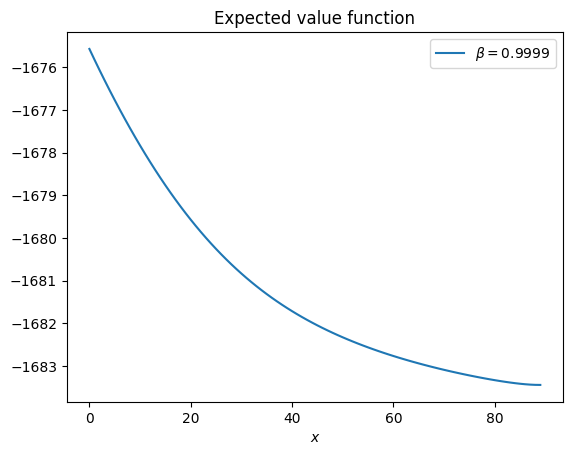

In [37]:
# Example for solving inner loop 

r = Rust(p=p, q=q) # Since have already set default values of the properties 'p', 'q', this essentially is equivalent to r = Rust() (HGH)
EV_star = solve_EV(r)
plt.plot(r.x, EV_star, label=rf'$\beta = {r.β}$')

plt.title('Expected value function')
plt.xlabel('$x$')
plt.legend()
plt.show()

In [38]:
# Solve outer loop

@njit
def conditional_probability(rust):

    β = rust.β
    x = rust.x
    P = rust.P

    # Solve inner loop
    EV = solve_EV(rust)

    # Based on Logit assumption(i.e. Discrete Choice under the Type-1 Extreme Value distribution of the error term), we calculate the exp(utility). (HGH)
    wait = u(x, 0, rust) + β * P @ EV # Vector
    replace = u(x[0], 1, rust) + β * EV[0] # Scalar
    P_wait = 1 / (1 + np.exp(replace - wait)) # Note that 'Scalar - Vector' functions as subtraction for all the element in Vector. (HGH)
    P_replace = 1 - P_wait
    
    return P_wait, P_replace

In [39]:
# Define the Log-Likelihood function

def log_likelihood(θ,             # Parameters to search over 
                   b_data,        # Data consists of states and decisions
                   p,             # Absorbing state probability
                   q):            # Transition state 1 probability

    # Guess of parameters
    θ_1, RC = θ

    # Set up model with guess
    r = Rust(θ_1=θ_1, RC=RC, p=p, q=q)

    # Solve inner loop and find choice
    # probabilities conditional on x and i
    P_wait, P_replace = conditional_probability(r)

    # Log likelihood is sum of conditional probabilities given observed data
    logL = 0
    for decision, state in zip(b_data.decision, b_data.state):
        state = int(state)

        # Wait
        if decision == 0:
            logL += np.log(P_wait[state])
        
        # Replace
        if decision == 1:
            logL += np.log(P_replace[state])

    return -logL

In [8]:
# parameter 'args' indicates fixed parameters. (HGH)
# Since the function 'log_likelihood' has four parameters, remaining parameter is θ. 'x0' is the value of θ for initial guess.
θ_star = minimize(log_likelihood, x0=(0.1, 10), args=(b_data, p, q)).x
θ_star

NameError: name 'log_likelihood' is not defined

In [ ]:
# Use the solution to set up a new model
r_star = Rust(p=p, q=q, θ_1=θ_star[0], RC=θ_star[1])
EV_star = solve_EV(r_star) # Expected utility in terms of dynamic

plt.plot(r_star.x, EV_star)
plt.title('Expected value at solution')
plt.xlabel('$x$')
plt.show()

P_star = pd.DataFrame(conditional_probability(r_star)).T
P_star.iloc[:, 0].plot(label='Pr(wait)', legend=True, title='Conditional probabilities', xlabel='$x$')
P_star.iloc[:, 1].plot(secondary_y=True, label='Pr(replace)', legend=True)
plt.show()